## Задание 5.1

На данных АА-теста с '2022-12-25' по '2022-12-31'. Нужно сделать симуляцию, как будто было проведено 
10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из 2 и 3 экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [2]:
# импорт необходимых библиотек

import pandas as pd
#import pandahouse
#import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# Подключение БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator'
}

# SQL Запрос на получение необходимых данных из БД

query = '''
SELECT 
  exp_group,
  user_id,
  COUNT(action) FILTER (WHERE action = 'like') AS "likes",
  COUNT(action) FILTER (WHERE action = 'view') AS "views",
  COUNT(action) FILTER (WHERE action = 'like') / 
  COUNT(action) FILTER (WHERE action = 'view') AS "CTR"
FROM 
  simulator_20230120.feed_actions
WHERE 
  exp_group IN (2, 3)
  AND DATE(time) BETWEEN '2022-12-25' AND '2022-12-31'
GROUP BY 
  exp_group,
  user_id
'''

In [4]:
# Формируем датафрейм из полученных данных

df = pandahouse.read_clickhouse(query, connection=connection)

In [12]:
# Если нет доступа к базе данных.
df = pd.read_csv('data_for_AA_test.csv', index_col='Unnamed: 0')

In [8]:
# Проверяем корректность сформированного датафрейма

print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17049 entries, 0 to 17048
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  17049 non-null  int64  
 1   user_id    17049 non-null  int64  
 2   likes      17049 non-null  int64  
 3   views      17049 non-null  int64  
 4   CTR        17049 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 799.2 KB
None


,exp_group,user_id,likes,views,CTR
0,3,115383,11,36,0.305556


##### Данные содержат следующие столбцы:
- номер тестовой группы пользователя (exp_group);
- Id пользователя (user_id);
- Кол-во лайков пользователя (likes);
- Кол-во просмотренных постов пользователем (views);
- Соотношение кол-ва лайков на просмотренные посты (CTR).

In [101]:
#def split_user (user_id, salt, n_group):
#    salt_id = str(user_id) + '-' + str(salt)
#    hash_id_salt = hashlib.md5(salt_id.encode('ascii')).hexdigest()
#    hash_id_int = int(hash_id_salt, 16)
#    return hash_id_int % n_group

In [9]:
# Посмотрим на равномерность распределения пользователей между необходимыми тестовыми группами.

df.exp_group.value_counts()

3    8569
2    8480
Name: exp_group, dtype: int64

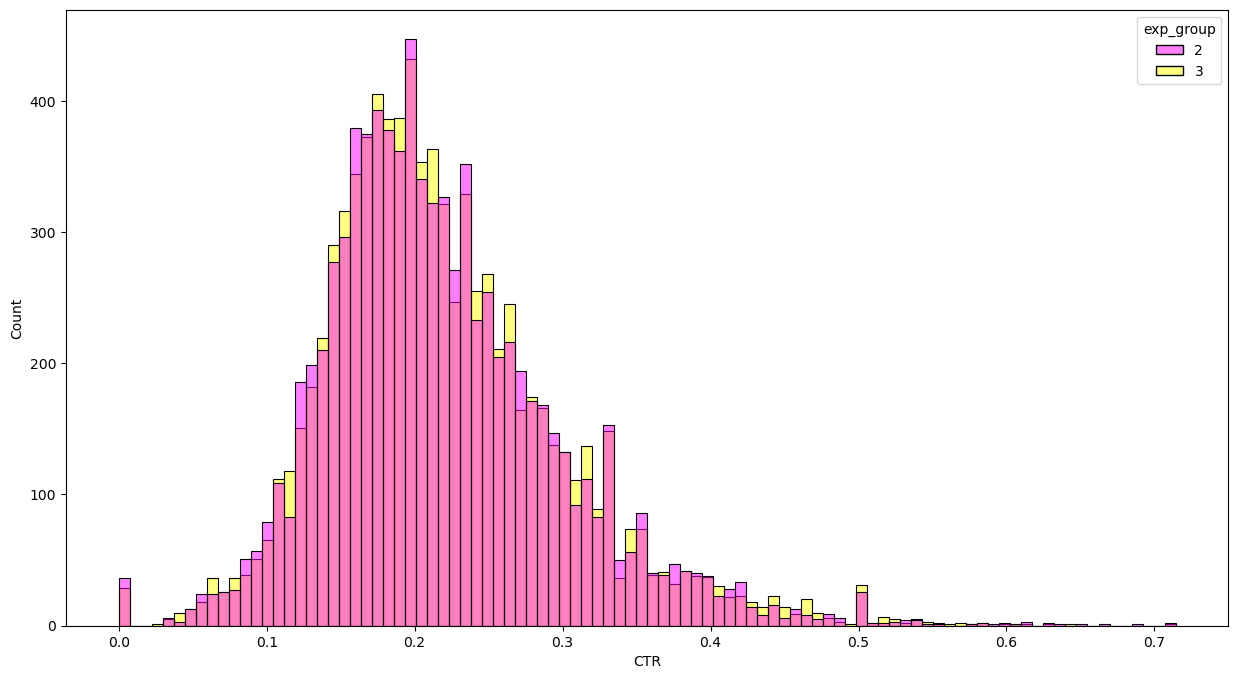

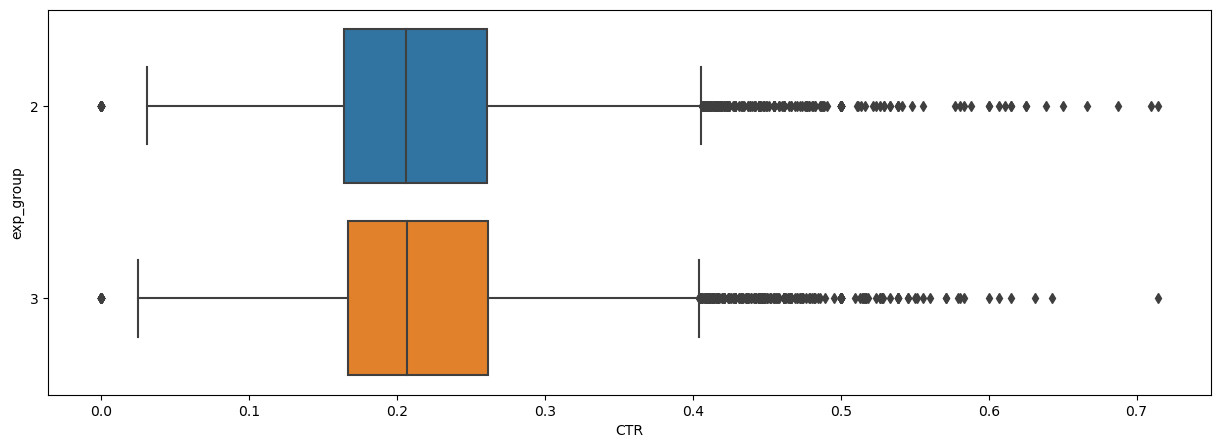

In [10]:
# Построим boxplot и гистограмму распределния интересущей нас метрики "CTR" с разделением на тестовые группы, чтобы визуально сравнить две выборки.

plt.figure(figsize=(15, 8))
sns.histplot(x=df.CTR, hue=df.exp_group, palette='spring')
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=df.CTR, y=df.exp_group, orient='h')
plt.show()

##### В, интересующих нас, тестовых группах 2 и 3 содержится примерно равное кол-во пользователей, а именно 8480 и 8569 соответственно. При визуальном анализе графиков, можно сказать, что распределение CTR у пользователей в группах примерно равное.

In [11]:
# Расчитаем t-критерий Стьюдента.

st, pvalue = stats.ttest_ind(a=df.CTR[df.exp_group == 2], b=df.CTR[df.exp_group == 3], equal_var=False)
print(f'Значение t-критерия = {round(st, 2)}, p-value = {round(pvalue, 2)}.')

Значение t-критерия = -0.74, p-value = 0.46.


При установленном уровне α = 5%, полученное значение p-value 0,46 - значительно привешающее уровень 0,05 не дает нам основания отвергнуть H0, а следовательно мы принимаем H0, котороая гласит о равенстве средних значений в сравниваемых выборках.
    
Теперь перейдем непосредственно к заданию. Необходимо из каждой выборки вытащить подвыборку размером в 500 наблюдений без повторения значений и сравнить полученные подвыборки t-критерием, и так 10 000 раз.

In [9]:
list_pvalue = []  # Создадим список, куда будем записывать значения p-value после каждого сравнения подвыборок.
for i in range(10000):  # С помощью цикла произведем необходимые вычисления 10 000 раз. На вход функции дадим две подвыборки из 500 наблюдений без повторенийЮ затем добавим результат p-value в ранее созданный список.
    st, pvalue = stats.ttest_ind(df.CTR[df.exp_group == 2].sample(500, replace=False),\
                                 df.CTR[df.exp_group == 3].sample(500, replace=False),\
                                 equal_var=False)
    list_pvalue.append(pvalue)

In [10]:
# Преобразуем список p-value в датафрейм.

df_pvalue = pd.DataFrame(list_pvalue, columns={'p_value'})

In [11]:
# Проверим датафрейм, что он действительно содержит 10 000 значений.

df_pvalue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   p_value  10000 non-null  float64
dtypes: float64(1)
memory usage: 78.2 KB


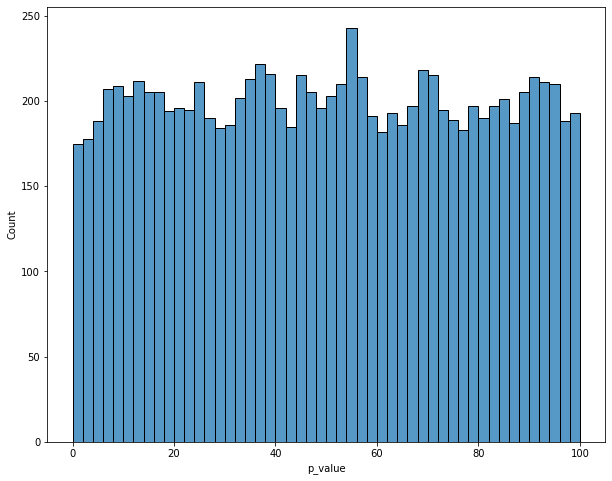

In [12]:
# Построим гистограмму распределения значений p-value.

plt.figure(figsize=(10, 8))
sns.histplot(x=df_pvalue.p_value * 100, bins=50)
plt.show()

In [13]:
# Расчитаем долю p-value меньших или равных уровню 0,05.

print(f'Доля p-value меньших или равных установленому α = {len(df_pvalue[df_pvalue.p_value <= 0.05]) / len(df_pvalue) * 100}%.')

Доля p-value меньших или равных установленому α = 4.3999999999999995%.


### На основании полученных результатов t-критерия и p-value при сравнении выборок как целиком, так и при сравнении подвыборок из 500 наблюдений (10 000 раз повторений) Мы с уверенностью соглашаемся с  Н0 (нулевая гепотиза) о том, что среднии значения выборок равны. Значение p-value, позволяющее отклонить Н0 и принять Н1 (среднии значения выборок отличаются) появилось не более чем в 4,39% случаев при прогонки теста 10 000 раз, что не привышает установленный уровень α. Следовательно можно утверждать, что система сплитования сработала корректно и на полученных группах можно проводить дальнейшее АВ тестирование.